# Exam number: Y3892609

# Question 1

Import packages, load data and instantiate scaler and PCA

In [ ]:
%pip install numpy pandas scikit-learn torch torchvision scipy matplotlib gensim

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

q1_data = pd.read_csv("PADL-Q1.csv")
pca = PCA(n_components=q1_data.shape[1])

Apply PCA to scaled data (scaling is needed for SVD)

In [2]:
q1_data_scaled = scale(q1_data)
q1_pcs = pca.fit_transform(q1_data_scaled)

Check the minimum number of dimensions required to minimize loss of information

In [7]:
total_variance = sum(q1_pcs.var(axis=0))
for num_components in range(1, q1_pcs.shape[1]):
    first_n_comp_variance = (
        sum(q1_pcs[:, 0:num_components].var(axis=0)) / total_variance
    ) * 100
    print(
        f"The first {num_components} principal components correspond to {first_n_comp_variance.round(2)}% of the total variance"
    )

The first 1 principal components correspond to 40.32% of the total variance
The first 2 principal components correspond to 70.24% of the total variance
The first 3 principal components correspond to 81.51% of the total variance
The first 4 principal components correspond to 91.95% of the total variance


Reducing the number of dimensions to four allows for a relatively small loss of information - the 4 components correspond to around 92 percent of the total variance. Therefore, $D_{min}=4$

In [8]:
pca_min_dims = PCA(n_components=4)
q1_pcs_min_dimensions = pca_min_dims.fit_transform(q1_data_scaled)
components = pca_min_dims.components_
components

array([[-0.55608777,  0.16605693, -0.55968369,  0.2074285 , -0.55400277],
       [-0.07616798, -0.68491569, -0.21946827, -0.67209755, -0.15876868],
       [-0.58290436,  0.2674771 , -0.13665832, -0.32308723,  0.68236182],
       [ 0.56104011,  0.48673801, -0.55197578, -0.37899935, -0.00152482]])

Above are the four principal component directions that allow the data to be reduced in dimensions with minimal loss of data. Note that the components are returned in the order of decreasing explained variance according to the function's documentation

Individual principal components can be found by performing matrix multiplication between each component direction and the original input.
The equations to calculate the individual components, in order of decreasing explained variance are therefore as follows:

$$PC_{0} = \begin{bmatrix} 
xScaled_{1_{1}} & xScaled_{2_{1}} & xScaled_{3_{1}} & xScaled_{4_{1}} & xScaled_{5_{1}} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
xScaled_{1_{200}} & xScaled_{2_{200}} & xScaled_{3_{200}} & xScaled_{4_{200}} & xScaled_{5_{200}}
\end{bmatrix} \times \begin{bmatrix} -0.556088 \\ 0.166057 \\ -0.559684 \\ 0.207428 \\ -0.554003 \end{bmatrix}$$

$$PC_{1} = \begin{bmatrix} 
xScaled_{1_{1}} & xScaled_{2_{1}} & xScaled_{3_{1}} & xScaled_{4_{1}} & xScaled_{5_{1}} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
xScaled_{1_{200}} & xScaled_{2_{200}} & xScaled_{3_{200}} & xScaled_{4_{200}} & xScaled_{5_{200}}
\end{bmatrix} \times \begin{bmatrix} -0.076268 \\ -0.684916 \\ -0.219468 \\ -0.672098 \\ -0.158769 \end{bmatrix}$$

$$PC_{2} = \begin{bmatrix} 
xScaled_{1_{1}} & xScaled_{2_{1}} & xScaled_{3_{1}} & xScaled_{4_{1}} & xScaled_{5_{1}} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
xScaled_{1_{200}} & xScaled_{2_{200}} & xScaled_{3_{200}} & xScaled_{4_{200}} & xScaled_{5_{200}}
\end{bmatrix} \times \begin{bmatrix} -0.582904 \\ 0.267477 \\ -0.136658 \\ -0.323087 \\ 0.682362 \end{bmatrix}$$

$$PC_{3} = \begin{bmatrix} 
xScaled_{1_{1}} & xScaled_{2_{1}} & xScaled_{3_{1}} & xScaled_{4_{1}} & xScaled_{5_{1}} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
xScaled_{1_{200}} & xScaled_{2_{200}} & xScaled_{3_{200}} & xScaled_{4_{200}} & xScaled_{5_{200}}
\end{bmatrix} \times \begin{bmatrix} 0.561040 \\ 0.486738 \\ -0.551976 \\ -0.378999 \\ -0.001525 \end{bmatrix}$$

Test that the above equations are correct (accounting for floating point arithmetic)

In [10]:
assert np.allclose(np.dot(q1_data_scaled, components[0]), q1_pcs_min_dimensions[:, 0])
assert np.allclose(np.dot(q1_data_scaled, components[1]), q1_pcs_min_dimensions[:, 1])
assert np.allclose(np.dot(q1_data_scaled, components[2]), q1_pcs_min_dimensions[:, 2])
assert np.allclose(np.dot(q1_data_scaled, components[3]), q1_pcs_min_dimensions[:, 3])

# Question 2

In [1]:
import pandas as pd

q2_data = pd.read_csv("PADL-Q2-train.csv")
q2_data.head()
q2_data_X, q2_data_y = q2_data.drop(columns=["out"]), q2_data["out"]

Split the data into training and testing sets - even though there is a whole separate testing set, reserve a small portion of the training data to examine the models' performance on unseen data

Examine the relationships between each variable and the "out" column

Text(0, 0.5, 'out')

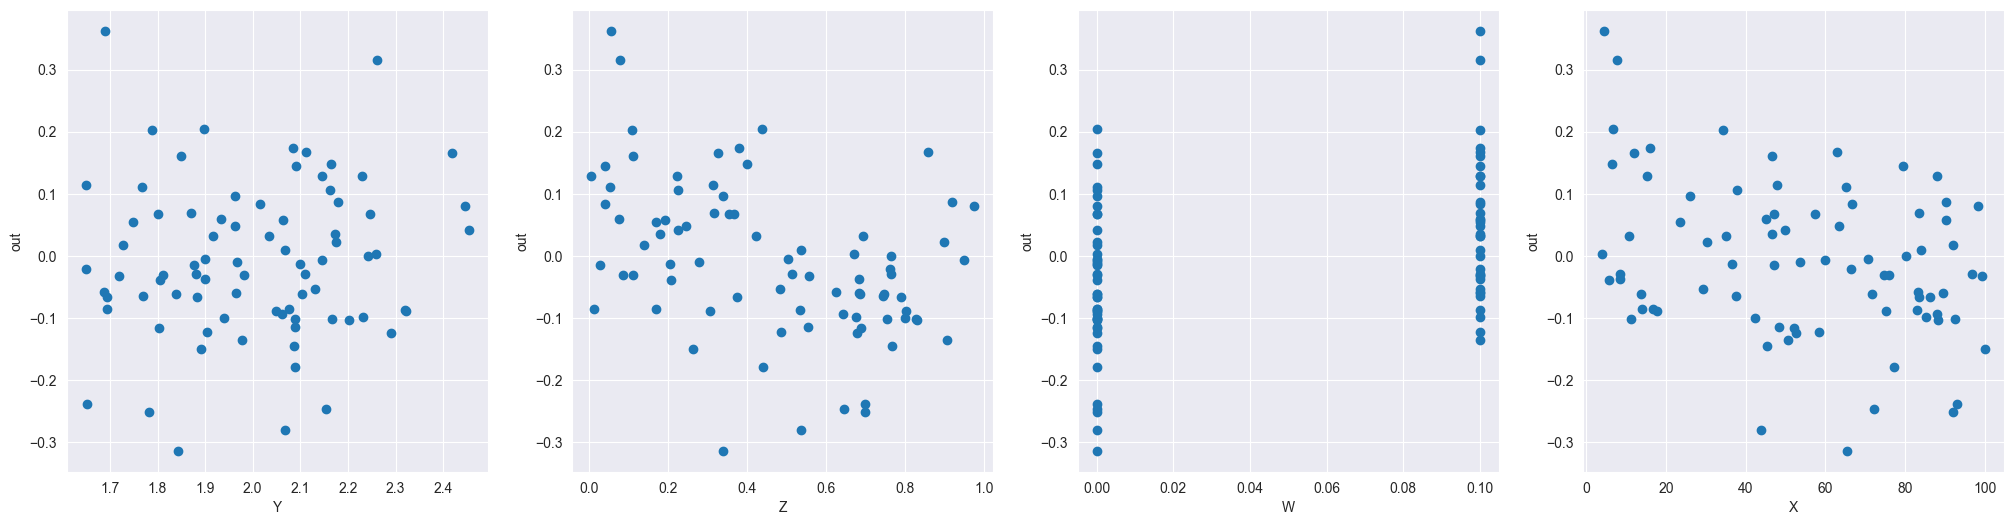

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(25, 6))
ax[0].scatter(q2_data["y"], q2_data["out"])
ax[0].set_xlabel("Y")
ax[0].set_ylabel("out")
ax[1].scatter(q2_data["z"], q2_data["out"])
ax[1].set_xlabel("Z")
ax[1].set_ylabel("out")
ax[2].scatter(q2_data["w"], q2_data["out"])
ax[2].set_xlabel("W")
ax[2].set_ylabel("out")
ax[3].scatter(q2_data["x"], q2_data["out"])
ax[3].set_xlabel("X")
ax[3].set_ylabel("out")

Display the correlation between each variable and the "out" column

In [3]:
q2_data.corr("pearson")["out"].drop("out")

x   -0.334637
y    0.084504
z   -0.424260
w    0.387800
Name: out, dtype: float64

It can be seen that the correlation between the "y" variable and the output is much smaller than those of the other columns. Therefore, it could be beneficial to remove that variable as that would allow for smaller models that would be able to converge easier. It would also make implementing polynomial features less memory-demanding as there will be less variables to fit to.

In [4]:
q2_data_X = q2_data_X.drop(columns=["y"])

Create the training and testing datasets. Because the final model will be evaluated on a separate dataset, it makes sense to use more data than the usual 80% to fit the model to capture as many of the dataset's features as possible.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    q2_data_X,
    q2_data_y,
    train_size=0.9,
    random_state=555,  # for repeatable results
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((72, 3), (72,), (8, 3), (8,))

Setup a training loop to pick from several preprocessing methods, polynomial feature counts and regression models. 
In terms of models, the main considered options are linear regression models with either Lasso (L1) or ridge (L2) regularisation to ensure the smallest possible weights within the model.
Furthermore, models making use of cross-validation will also be added to the training loop to examine its effects.
To evaluate a model, it will be fitted to the training set and evaluated on the testing set in terms of its $R^2$ score.

To investigate the effect of piecewise regression on the performance of the models, a `SplineTransformer` will be added to the list of basis functions applied to the data.

In [6]:
from sklearn.linear_model import (
    RidgeCV,
    LassoCV,
    Ridge,
    Lasso,
    LinearRegression,
    ElasticNetCV,
    ElasticNet,
)
from sklearn.preprocessing import (
    PolynomialFeatures,
    Normalizer,
    MinMaxScaler,
    StandardScaler,
    SplineTransformer,
)
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.exceptions import ConvergenceWarning
from scipy.linalg import LinAlgWarning
import warnings

warnings.simplefilter(
    "ignore", category=ConvergenceWarning
)  # Some models (particularly with high numbers of polynomial features) may fit poorly to the data, ignore those warnings
warnings.simplefilter("ignore", category=LinAlgWarning)
num_poly_features = [1, 2, 3, 4, 5]
models = [
    # Cross-validation + regularisation, fitting to intercept
    RidgeCV(fit_intercept=True),
    LassoCV(fit_intercept=True),
    ElasticNetCV(fit_intercept=True),  # Combines Ridge and Lasso regression
    # Regularisation only
    Ridge(fit_intercept=True),
    Lasso(fit_intercept=True),
    ElasticNet(fit_intercept=True),
    # No regularisation, plain linear regression
    LinearRegression(fit_intercept=True),
    # Cross-validation + regularisation, not fitting to intercept
    RidgeCV(fit_intercept=False),
    LassoCV(fit_intercept=False),
    ElasticNetCV(fit_intercept=False),
    # Regularisation only
    Ridge(fit_intercept=False),
    Lasso(fit_intercept=False),
    ElasticNet(fit_intercept=False),
    # Plain linear regression
    LinearRegression(fit_intercept=False),
]
preprocessing = [
    MinMaxScaler(),  # Scale each value to a range of [0, 1]
    StandardScaler(),  # Scale data to unit variance
    Normalizer(),  # Normalize data
]

feature_transformers = [
    PolynomialFeatures(2),
    PolynomialFeatures(3),
    PolynomialFeatures(4),
    PolynomialFeatures(5),
    SplineTransformer(n_knots=2, degree=2),
    SplineTransformer(n_knots=2, degree=3),
    SplineTransformer(n_knots=2, degree=4),
    SplineTransformer(n_knots=2, degree=5),
    SplineTransformer(n_knots=3, degree=2),
    SplineTransformer(n_knots=3, degree=3),
    SplineTransformer(n_knots=3, degree=4),
    SplineTransformer(n_knots=3, degree=5),
    SplineTransformer(n_knots=4, degree=2),
    SplineTransformer(n_knots=4, degree=3),
    SplineTransformer(n_knots=4, degree=4),
    SplineTransformer(n_knots=4, degree=5),
]
best_r2 = -100000
best_model = None
for transformer in feature_transformers:
    for model in models:
        for proc in preprocessing:
            pipeline = make_pipeline(proc, transformer, model)
            pipeline.fit(X_train, y_train)
            current_r2 = r2_score(y_test, pipeline.predict(X_test))
            if current_r2 > best_r2:
                best_r2 = current_r2
                best_model = pipeline
                print(f"New best score: {r2_score(y_test, pipeline.predict(X_test))}")
warnings.resetwarnings()

New best score: 0.4035063064639358
New best score: 0.45375950251641317
New best score: 0.5265200236761375
New best score: 0.593885029960604
New best score: 0.6116224949012445


The best r^2 score on testing data is 0.6116224949012445
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('ridgecv', RidgeCV(fit_intercept=False))])


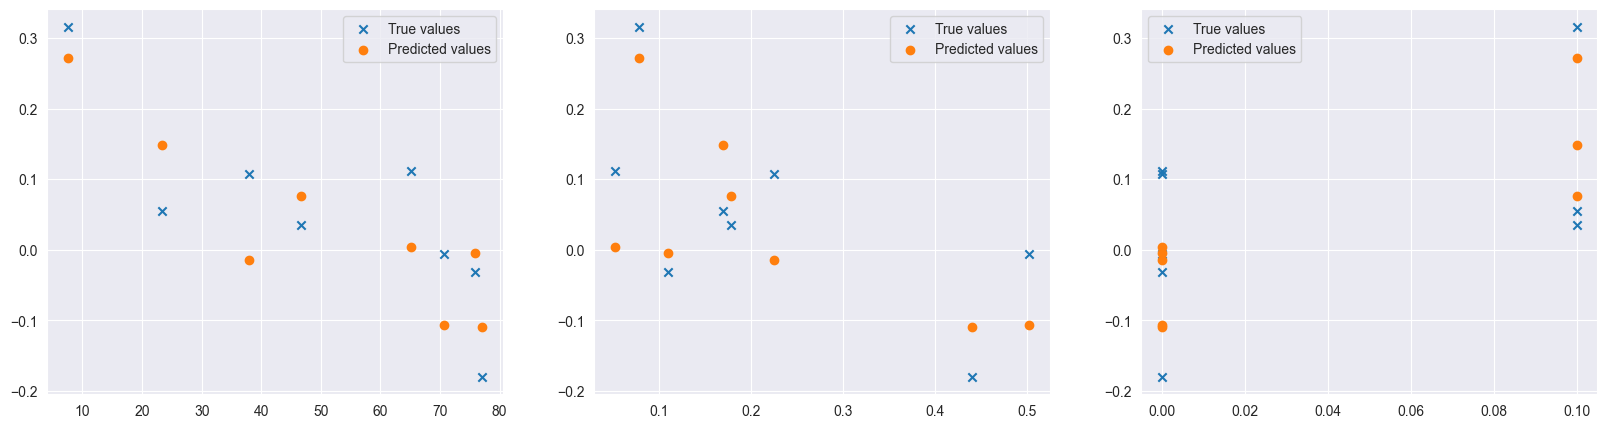

In [7]:
import matplotlib.pyplot as plt

print(f"The best r^2 score on testing data is {best_r2}")
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(X_test["x"], y_test, marker="x", label="True values")
ax[0].scatter(X_test["x"], preds, label="Predicted values")
ax[0].legend()

ax[1].scatter(X_test["z"], y_test, marker="x", label="True values")
ax[1].scatter(X_test["z"], preds, label="Predicted values")
ax[1].legend()

ax[2].scatter(X_test["w"], y_test, marker="x", label="True values")
ax[2].scatter(X_test["w"], preds, label="Predicted values")
ax[2].legend()
print(best_model)

From the above cell, the best model is a pipeline consisting of a standard scaler, a polynomial feature expansion to the power of 4 and a Ridge regression, not fitting to the origin and making use of cross-validation

## Evaluating the model on the unseen dataset (question 2.c)

In [8]:
best_model = make_pipeline(
    StandardScaler(), PolynomialFeatures(4), RidgeCV(fit_intercept=False)
)
best_model.fit(q2_data_X, q2_data_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('ridgecv', RidgeCV(fit_intercept=False))])

**Note:** this assumes that both the training and unseen datasets for q2 are in the same directory as the notebook.

In [9]:
q2_unseen = pd.read_csv("PADL-Q2-unseen.csv")
q2_unseen_X, q2_unseen_y = q2_unseen.drop(columns=["out", "y"]), q2_unseen["out"]

unseen_predictions = best_model.predict(q2_unseen_X)
print(
    f"The r^2 score of the best model on the unseen dataset is {r2_score(q2_unseen_y, unseen_predictions)}"
)

The r^2 score of the best model on the unseen dataset is 0.6243380160590496


# Question 3

Download the book text

In [10]:
!curl -o sherlock.txt https://www.gutenberg.org/cache/epub/48320/pg48320.txt -s

In [11]:
L = ["gold", "diamond", "robbery", "bank", "police"]

Capture all triplets matching the pattern 'X and Y'

In [12]:
import re

pattern = re.compile(
    r"(?=("  # We need a lookahead because triplets can overlap (e.g. 'X and Y and Z'), normal regex will not capture the second triplet
    r"(?<![a-zA-Z-])"  # Negative lookbehind, ensuring that each triplet starts at the beginning of the first word.
    r"[a-zA-z]+"  # At least one letter (so we don't capture triplets like ', and then')
    r"[\S]*"  # Any number of further letters and/or punctuation except whitespace
    r"\s+"  # At least one whitespace character (newline, tab, space, etc.)
    r"[Aa]nd"  # 'And' or 'and'
    r"\s+"  # At least one whitespace character
    r"[a-zA-z]+"  # At least one letter
    r"[\S]*"  # Any number of further letters and/or punctuation
    r"))"
)
print(pattern.findall("testing and trialling"))  # Can capture a single triplet
print(pattern.findall("X and Y and Z"))  # Can capture overlapping triplets
print(pattern.findall("tight-fitting and sleek"))  # Can capture hyphenated words
print(pattern.findall("One And two"))  # Case-insensitive for and
print(
    pattern.findall("This is the end of one sentence. And so, another begins.")
)  # Can capture triplets across sentences
print(
    pattern.findall(
        """
This is the end of one sentence.
And the other is on a new line.
"""
    )
)  # Can handle line breaks
print(
    pattern.findall("What?! And you're only telling me now?")
)  # Can handle other punctuation

['testing and trialling']
['X and Y', 'Y and Z']
['tight-fitting and sleek']
['One And two']
['sentence. And so,']
['sentence.\nAnd the']
["What?! And you're"]


In [13]:
with open("sherlock.txt") as sherlock_file:
    sherlock_full_text = (
        sherlock_file.read()
    )  # full text needed to train the model later
    captured_triplets = pattern.findall(sherlock_full_text)
captured_triplets = [
    re.sub(re.compile(r"\s"), " ", triplet) for triplet in captured_triplets
]  # Replace whitespace (tabs, newlines, etc) characters with spaces
print(f"Found {len(captured_triplets)} triplets")

Found 2915 triplets


Process the text of sherlock holmes into sentences

In [14]:
sentences = sherlock_full_text.split(". ")
words = [sentence.split(" ") for sentence in sentences]
sentences = [sentence.encode("utf-8") for sentence in sentences]

Create a convenience function to compare the length of the shared suffixes: start at the end of each word and iterate backwards until the first pair of letters does not match

In [15]:
def shared_suffix_length(word1: str, word2: str) -> int:
    suffix_length = 0
    for l1, l2 in zip(word1[::-1], word2[::-1]):
        if l1.lower() == l2.lower():
            suffix_length += 1
        else:
            return suffix_length
    return suffix_length


assert shared_suffix_length("bold", "gold") == 3
assert shared_suffix_length("lobster", "mobster") == 6
assert shared_suffix_length("apple", "potato") == 0

Find triplets where the last word shares a suffix of 3 with the first word

In [16]:
rhymes = {}
for word in L:
    rhymes[word] = [
        re.sub(
            "[.,_]", "", triplet
        ).lower()  # remove any punctuation and convert to lowercase for consistency
        for triplet in captured_triplets
        if shared_suffix_length(
            word,
            re.sub(r"\s+", " ", triplet).split(" ")[
                2
            ],  # Remove any repeating whitespace
        )
        >= 3  # Check that the second word in the triplet and the target word share at least 3 letters
    ]
rhymes

{'gold': ['away and told', 'rapidly and told', 'indemnify and hold'],
 'diamond': [],
 'robbery': ['delicacy and every',
  'pay and very',
  'ten and every',
  'abbots and archery',
  'police and every',
  'air and scenery',
  'long and very',
  'arm-chair and cheery',
  'police and very'],
 'bank': ['do and frank', 'mercifully and thank'],
 'police': ['help and advice']}

There are less than 5 triplets ending in words that share 3 letters with the words "Diamond", "Police", "Bank" and "Gold". To a good variety of triplets for every word, relax the requirement such that only 2 letters have to be shared

In [17]:
for word in ["diamond", "police", "gold", "bank"]:
    rhymes[word] = [
        re.sub(
            "[.,-_]", "", triplet
        ).lower()  # remove any punctuation and convert to lowercase for consistency
        for triplet in captured_triplets
        if shared_suffix_length(
            word,
            re.sub(r"\s+", " ", triplet).split(" ")[
                2
            ],  # Remove any repeating whitespace
        )
        >= 2
    ]
rhymes

{'gold': ['finger and held',
  'handy and would',
  'away and told',
  'gun and held',
  'you and would',
  'skill and would',
  'keys and could',
  'frenzy and would',
  'out and would',
  'stone and held',
  'strongbox and held',
  'estate and would',
  'handkerchief and held',
  'safe and should',
  'rapidly and told',
  'blue and would',
  'indemnify and hold'],
 'diamond': ['year and found',
  'assistant and found',
  'good and kind',
  'forward and found',
  'cry and found',
  'today and send',
  'ock and found',
  'packet and found',
  'right and found',
  'yard and behind',
  'myself nd now—and',
  'round and round',
  'rope and land',
  'consultingroom and found',
  'up and hand',
  'up and found',
  'lodgings and found',
  'night and find',
  'passage and found',
  'out and round'],
 'robbery': ['delicacy and every',
  'pay and very',
  'ten and every',
  'abbots and archery',
  'police and every',
  'air and scenery',
  'long and very',
  'arm-chair and cheery',
  'police an

"Bank" is still at less than 5 rhymes, but reducing the requirement to 1 letter is likely to produce triplets which rhyme with the word even less than those who share 2

Load up a pre-trained word2vec model

In [20]:
from gensim import downloader as api
from gensim.models import Word2Vec

# Load the glove-wiki-gigaword-100 pre-trained word2vec model
model = api.load("glove-wiki-gigaword-100")
sherlock_model = Word2Vec(vector_size=100, min_count=1, epochs=30)
sherlock_model.build_vocab(
    sentences
)  # Build vectors from the full sherlock text. Vector size is 100 to match with the pretrained model
total_examples = sherlock_model.corpus_count
sherlock_model.build_vocab([list(model.key_to_index.keys())], update=True)
sherlock_model.wv.vectors_lockf = np.ones(len(sherlock_model.wv))
sherlock_model.wv.intersect_word2vec_format(
    "~/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz",
    binary=False,
    lockf=1.0,
)
sherlock_model.train(sentences, total_examples=total_examples, epochs=30)

(3958852, 18043380)

Create a utility function to give a 'similarity score' to a triplet

In [21]:
def similarity_score(triplet: str) -> float:
    first_word = triplet.split(" ")[0]
    last_word = triplet.split(" ")[2]
    try:
        return sherlock_model.wv.similarity(first_word, last_word)
    except KeyError:  # a mistake in regex or a rogue punctuation mark causing a word not to be recognised in the model's dictionary
        return -1

In [22]:
for word, triplets in rhymes.items():
    top_5_similar_triplets = sorted(
        triplets,
        key=similarity_score,  # compare using the similarity score function from the above cell
        reverse=True,  # return in descending order i.e. largest similarity first
    )[0:5]
    print(f"The best 5 cockney rhymes for word '{word}' are: {top_5_similar_triplets}")

The best 5 cockney rhymes for word 'gold' are: ['out and would', 'you and would', 'safe and should', 'away and told', 'blue and would']
The best 5 cockney rhymes for word 'diamond' are: ['round and round', 'good and kind', 'up and hand', 'up and found', 'out and round']
The best 5 cockney rhymes for word 'robbery' are: ['long and very', 'ten and every', 'police and every', 'pay and very', 'police and very']
The best 5 cockney rhymes for word 'bank' are: ['do and rank', 'mercifully and thank', 'screamed and shrunk']
The best 5 cockney rhymes for word 'police' are: ['head and face', 'problems and since', 'men and once', 'help and advice', 'dead and once']


# Question 4

Pick a device for this question and the rest of the PyTorch section

In [10]:
import torch

DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else (
        "mps" if torch.backends.mps.is_available() else "cpu"
    )  # Local training done on Apple Silicon, check if MPS backend is available
)
DEVICE

'mps'

## Defining the training data range

To reduce the search space of the model and converge faster, limit the range of training data between -100 and 100. While this will limit the generalisation abilities of the model, it will still show its ability to fit to a dataset.

In [635]:
import torch
from sklearn.model_selection import train_test_split

NUMBER_RANGE = np.arange(-100, 100, 1)

In [636]:
lefts = torch.tensor(NUMBER_RANGE, dtype=torch.float32)
rights = torch.tensor(NUMBER_RANGE, dtype=torch.float32)
X = torch.cartesian_prod(lefts, rights)
y = torch.tensor(np.prod(X.numpy(), axis=1), dtype=torch.float32).unsqueeze(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [637]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1),
).to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.L1Loss()
scheduler = torch.optim.lr_scheduler.StepLR(
    optim, step_size=15000, gamma=0.1
)  # The Adam optimizer tends to need some 'help' after the first 15000 epochs, reducing the learning rate for the last bit helps it reduce the loss further.
epochs = 20000

In [638]:
for epoch in range(epochs):
    y_predict = model(X_train.to(DEVICE))
    loss = criterion(y_train.to(DEVICE), y_predict)
    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()
    if not epoch % 1000:
        print(f"Epoch: {epoch}, loss: {loss}")

Epoch: 0, loss: 2509.9150390625
Epoch: 1000, loss: 511.0423278808594
Epoch: 2000, loss: 221.7447052001953
Epoch: 3000, loss: 47.00261306762695
Epoch: 4000, loss: 25.44416618347168
Epoch: 5000, loss: 12.703668594360352
Epoch: 6000, loss: 14.923758506774902
Epoch: 7000, loss: 10.67779541015625
Epoch: 8000, loss: 11.76170825958252
Epoch: 9000, loss: 10.944426536560059
Epoch: 10000, loss: 11.468090057373047
Epoch: 11000, loss: 9.763555526733398
Epoch: 12000, loss: 11.353529930114746
Epoch: 13000, loss: 10.656126022338867
Epoch: 14000, loss: 11.264410972595215
Epoch: 15000, loss: 9.730481147766113
Epoch: 16000, loss: 3.808769702911377
Epoch: 17000, loss: 3.6367526054382324
Epoch: 18000, loss: 3.581014633178711
Epoch: 19000, loss: 3.498891592025757


In [644]:
def predict_pair(left, right):
    """
    Convenience method to make a single prediction and output the results using the trained model.
    :param left: the first number to multiply
    :param right: the second number to multiply
    """
    with torch.no_grad():
        prediction = model(
            torch.tensor([left, right], dtype=torch.float32, device=DEVICE)
        )
        actual = left * right
        print(
            f"Inputs: {left}, {right}\nPredicted value: {prediction.item()}\nActual value: {actual}\nAbsolute error: {abs(prediction.item() - actual)}"
        )

In [645]:
test_criterion = torch.nn.L1Loss()
with torch.no_grad():
    test_preds = model(X_test.to(DEVICE))
print(
    f"The mean absolute error of the model on the testing set is {test_criterion(test_preds, y_test.to(DEVICE)).item()}"
)

The mean absolute error of the model on the testing set is 3.454526901245117


Create some out of range pairs

In [646]:
X_out_of_range = torch.tensor(
    [
        [5, 5000],  # One item out of range (too large)
        [10, -3500],  # One item out of range (too small)
        [500, 1e5],  # Two items out of range (both too large)
        [-400, -500],  # Two items out of range (both too small)
        [1e5, -796],  # Two items out of range (one too large, one too small)
    ]
)
for pair in X_out_of_range:
    predict_pair(*pair)
    print("------------------------")

Inputs: 5.0, 5000.0
Predicted value: 2696.7919921875
Actual value: 25000.0
Absolute error: 22303.20703125
------------------------
Inputs: 10.0, -3500.0
Predicted value: 7294.1533203125
Actual value: -35000.0
Absolute error: 42294.15234375
------------------------
Inputs: 500.0, 100000.0
Predicted value: 128161.9921875
Actual value: 50000000.0
Absolute error: 49871840.0
------------------------
Inputs: -400.0, -500.0
Predicted value: 67699.6640625
Actual value: 200000.0
Absolute error: 132300.34375
------------------------
Inputs: 100000.0, -796.0
Predicted value: 178523.0625
Actual value: -79600000.0
Absolute error: 79778520.0
------------------------


In [649]:
y_out_of_range = torch.tensor(
    [pair[0] * pair[1] for pair in X_out_of_range], device=DEVICE
).unsqueeze(1)
with torch.no_grad():
    preds = model(X_out_of_range.to(DEVICE))
print(
    f"The mean absolute error of the model on the unseen, out of range data is {test_criterion(y_out_of_range, preds).item()}"
)

The mean absolute error of the model on the unseen, out of range data is 25969452.0


As seen, the model's predictions outside of the training range are nearly meaningless.

Despite this, model was able to fit to the in-range data well - on average, it is mistaken by 4.47 when multiplying numbers between -100 and 100. This is quite a narrow range, however the task of multiplication is not one that suits a neural network well, as on a basic level, the outputs of each layer are summed rather than multiplied. However, the Universal Approximation Theorem states that a single-layer MLP is able to approximate any function, though limited to a specific range. This is clearly seen in this example, where the network has successfully fit itself to the training range without demonstrating any signs of fitting to data beyond it.

# Question 5

## Defining the dataloader
Loading images is done in line with the pytorch tutorial and no departure from their method was needed.
In terms of defining the label, the cyclical nature of the data suggested that harmonic regression could be a good choice for this task.
A good representation of the data, therefore, was seen in representing each clock with 4 numbers, encoding the sin and cos of the angles of the hour and minute hands with the 12o'clock mark.
This is convenient for multiple reasons: first, it limits the range of data to between -1 and 1, allowing an activation function like Tanh to fully capture the entire range.
Second, it penalises the model for its absolute deviation from the true value: by using sin and cos, the difference between 2 points in time remains consistent no matter the hand positions. 
For example, the difference between 11:55 and 0:05 is the same as the difference between 0:05 and 11:55 when encoded, whereas the raw value (e.g. minutes passed since midnight) would suggest that the two readings are significantly different.

In [65]:
import torch


def clock_to_sin_cos(hour, minute):
    """
    Encode the hour and minute readings of an analogue clock to the sin and cosine of the hands' angles with the vertical axis (00:00).
    :param hour: [0, 11]
    :param minute: [0, 59]
    :return: sin of hour angle, cos of hour angle, sin of minute angle, cos of minute angle [-1, 1]
    """
    # Calculate the angle of the hour hand from 12 o'clock: the hour hand moves 30 degrees every hour (0.5 degrees every minute)
    hour_angle_degrees = (
        hour * 30  # full hours
        + minute * 0.5
    )  # minutes

    # Calculate the angle of the minute hand from 12 o'clock (the minute hand moves 6 degrees every minute)
    minute_angle_degrees = minute * 6

    return (
        np.sin(np.radians(hour_angle_degrees)),
        np.cos(np.radians(hour_angle_degrees)),
        np.sin(np.radians(minute_angle_degrees)),
        np.cos(np.radians(minute_angle_degrees)),
    )


def sin_cos_to_clock(hour_sin, hour_cos, minute_sin, minute_cos):
    """
    Decode the sin and cosine values of each hand back into hour and minute readings.
    :return: hour ([0, 11]), minute ([0. 59])
    """
    # Calculate angles from sine and cosine values: arctan2 takes in sin and cosine and returns the angle (in radians)
    hour_angle = np.float32(np.degrees(np.arctan2(hour_sin, hour_cos)))
    minute_angle = np.float32(np.degrees(np.arctan2(minute_sin, minute_cos)))

    # Make sure angles don't exceed 360 degrees
    hour_angle %= 360
    minute_angle %= 360
    # Convert angles to hour and minute
    hour = np.floor(
        hour_angle / 30
    )  # It doesn't matter how far into the hour the hand is, only that it's in the 30 degree range that corresponds to that hour
    minute = minute_angle / 6

    return hour, minute

In [66]:
assert np.allclose((11, 37), sin_cos_to_clock(*clock_to_sin_cos(11, 37)))
assert np.allclose((0, 0), sin_cos_to_clock(*clock_to_sin_cos(0, 0)))
assert np.allclose((3, 43), sin_cos_to_clock(*clock_to_sin_cos(3, 43)))

In [4]:
from torch.utils.data import Dataset
import os
from torchvision.io import read_image
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt


class ClocksDataset(Dataset):
    def __init__(self, data_dir: str, transform=None):
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(
            glob(f"{self.data_dir}/*.png")
        )  # Return the count of png files in the data directory

    def __getitem__(self, item):
        # Take the index (a number) and convert it into the filename by padding with zeros until length 4 is reached. Item 0 gets converted to '0000', item 1042 is converted to '1042'
        filename = str(item).zfill(4)
        img_path = os.path.join(self.data_dir, f"{filename}.png")
        label_path = os.path.join(self.data_dir, f"{filename}.txt")
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        label = Path(label_path).read_text()
        hours, minutes = label.split(":")
        hours, minutes = int(hours), int(minutes)
        return (
            image,
            torch.tensor(clock_to_sin_cos(hours, minutes), dtype=torch.float32),
            f"{hours}:{minutes}",  # To visualise labels, not used in training
        )

In [6]:
from torchvision.transforms import v2
from torch.utils.data import SubsetRandomSampler, DataLoader
from sklearn.model_selection import train_test_split

transform = v2.Compose(
    [
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        v2.Resize((256, 256)),
    ]
)
train_indices, test_indices = train_test_split(
    range(10000),  # image names are just numbers so a range is fine here
    train_size=0.9,
)  # Train on more data than the usual 80% to better prepare the model for the testing set
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [15]:
dataset = ClocksDataset("train", transform)
train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=4)
test_loader = DataLoader(
    dataset, sampler=test_sampler, batch_size=100
)  # Use larger batches for faster processing

Visualise some training data

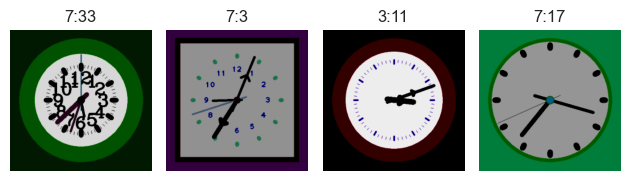

In [16]:
images, _, display_labels = next(iter(train_loader))
fig, ax = plt.subplots(1, 4)
for idx, (image, label) in enumerate(zip(images[0:4], display_labels[0:4])):
    ax[idx].imshow(image.permute(1, 2, 0).clamp(0, 1))
    ax[idx].set_axis_off()
    ax[idx].set_title(label)
fig.tight_layout()

## Defining the model architecture

This architecture is inspired by VGG, utilising blocks of convolutional layers followed by max pooling. It departs from the original architecture by adding batch normalisation, reducing the maximum number of channels and reducing the number of layers in the fully-connected portion of the network. This is done to keep the network's memory footprint compact as well as to prevent overfitting caused by the model being too complex. Another departure from the VGG architecture is the usage of Tanh as the output activation - this matches the representation into which the dataloader maps the labels. The output of the network is of shape Bx4, where B is the batch dimension.

In [28]:
import torch.nn as nn

relu = torch.nn.ReLU()


class ClockPredictor(torch.nn.Module):
    def __init__(self, device):
        super(ClockPredictor, self).__init__()
        self.device = device
        self.main = torch.nn.Sequential(
            # 3x256x256
            torch.nn.Conv2d(
                in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same"
            ),
            relu,
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(
                in_channels=32, out_channels=32, kernel_size=3, stride=1, padding="same"
            ),
            relu,
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(
                in_channels=32, out_channels=32, kernel_size=3, stride=1, padding="same"
            ),
            relu,
            torch.nn.BatchNorm2d(32),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 32x128x128
            torch.nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same"
            ),
            relu,
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=3, stride=1, padding="same"
            ),
            relu,
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=3, stride=1, padding="same"
            ),
            relu,
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64x64
            torch.nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding="same",
            ),
            relu,
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding="same",
            ),
            relu,
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding="same",
            ),
            relu,
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 128x32x32
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding="same",
            ),
            relu,
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding="same",
            ),
            relu,
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding="same",
            ),
            relu,
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 256x16x16
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding="same",
            ),
            relu,
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding="same",
            ),
            relu,
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding="same",
            ),
            relu,
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 256x8x8
            torch.nn.Flatten(),
            torch.nn.Linear(8 * 8 * 128, 128),
            relu,
            torch.nn.Linear(128, 64),
            relu,
            torch.nn.Linear(64, 4),  # sin_hour, cos_hour, sin_minute, cos_minute
            torch.nn.Tanh(),  # Since we are using sin and cosine, map to -1 and 1 instead of 0 and 1
        ).to(self.device)

    def forward(self, x):
        x = self.main(x)
        return x


model = ClockPredictor(DEVICE)

Test the model's output matches the expected shape (4 values, as described above)

In [29]:
imgs, labels, _ = next(iter(train_loader))
model(imgs.to(DEVICE)).shape, labels.shape

(torch.Size([4, 4]), torch.Size([4, 4]))

## Picking a loss function and running the training loop

Since the model is solving a regression task, it makes sense to define the loss based on some function of the model's error. For this task, L1 or mean absolute loss stood out as the best, since the data's small range ([-1, 1]) would make calculating squared error potentially lead to vanishing gradients. Therefore, the loss function will calculate the absolute error for each of the four values and add them together, ensuring that each of the 4 values contributes to the total loss.

The number of epochs is relatively low at 10, but the small batch size and large dataset size mean that the model's weights will be updated a large number of times.

In [30]:
clock_loss = torch.nn.L1Loss(reduction="sum")
clock_optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10
model.train()
train_losses = []
test_losses = []
best_test_loss = 1e9
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i, (images, labels, _) in enumerate(train_loader):
        output = model(images.to(DEVICE))
        loss = clock_loss(output, labels.to(DEVICE))
        clock_optimizer.zero_grad()
        loss.backward()
        clock_optimizer.step()
        total_loss += loss
    print("Total training loss over epoch {}: {:.2f}".format(epoch + 1, total_loss))
    train_losses.append(total_loss.item())
    model.eval()
    total_test_loss = 0
    for i, (test_images, test_labels, _) in enumerate(test_loader):
        with torch.no_grad():
            output = model(test_images.to(DEVICE))
        test_loss = clock_loss(output, test_labels.to(DEVICE))
        total_test_loss += test_loss
    print(f"Test loss over epoch {epoch + 1}: {round(total_test_loss.item(), 3)}")
    if total_test_loss.item() < best_test_loss:
        best_test_loss = total_test_loss.item()
        print("New best - storing weights...")
        torch.save(model.state_dict(), "q5-checkpoint-best-loss.pt")
    test_losses.append(total_test_loss.item())

Total training loss over epoch 1: 12931.34
Test loss over epoch 1: 1015.641
New best - storing weights...
Total training loss over epoch 2: 7320.66
Test loss over epoch 2: 781.191
New best - storing weights...
Total training loss over epoch 3: 5689.40
Test loss over epoch 3: 608.756
New best - storing weights...
Total training loss over epoch 4: 4852.74
Test loss over epoch 4: 599.486
New best - storing weights...
Total training loss over epoch 5: 4235.62
Test loss over epoch 5: 475.439
New best - storing weights...
Total training loss over epoch 6: 3811.42
Test loss over epoch 6: 474.268
New best - storing weights...
Total training loss over epoch 7: 3455.76
Test loss over epoch 7: 486.453
Total training loss over epoch 8: 3199.38
Test loss over epoch 8: 414.654
New best - storing weights...
Total training loss over epoch 9: 2947.15
Test loss over epoch 9: 374.904
New best - storing weights...
Total training loss over epoch 10: 2671.33
Test loss over epoch 10: 366.317
New best - stori

## Visualising the loss curves
Since the reduction of the loss function is set to `sum`, plotting the average loss per batch will lead to a false representation of the model's performance as the testing batch size is significantly larger. Therefore, dividing each point's value by the total number of images in the training/testing dataset will provide a clearer picture of the model's training progress.

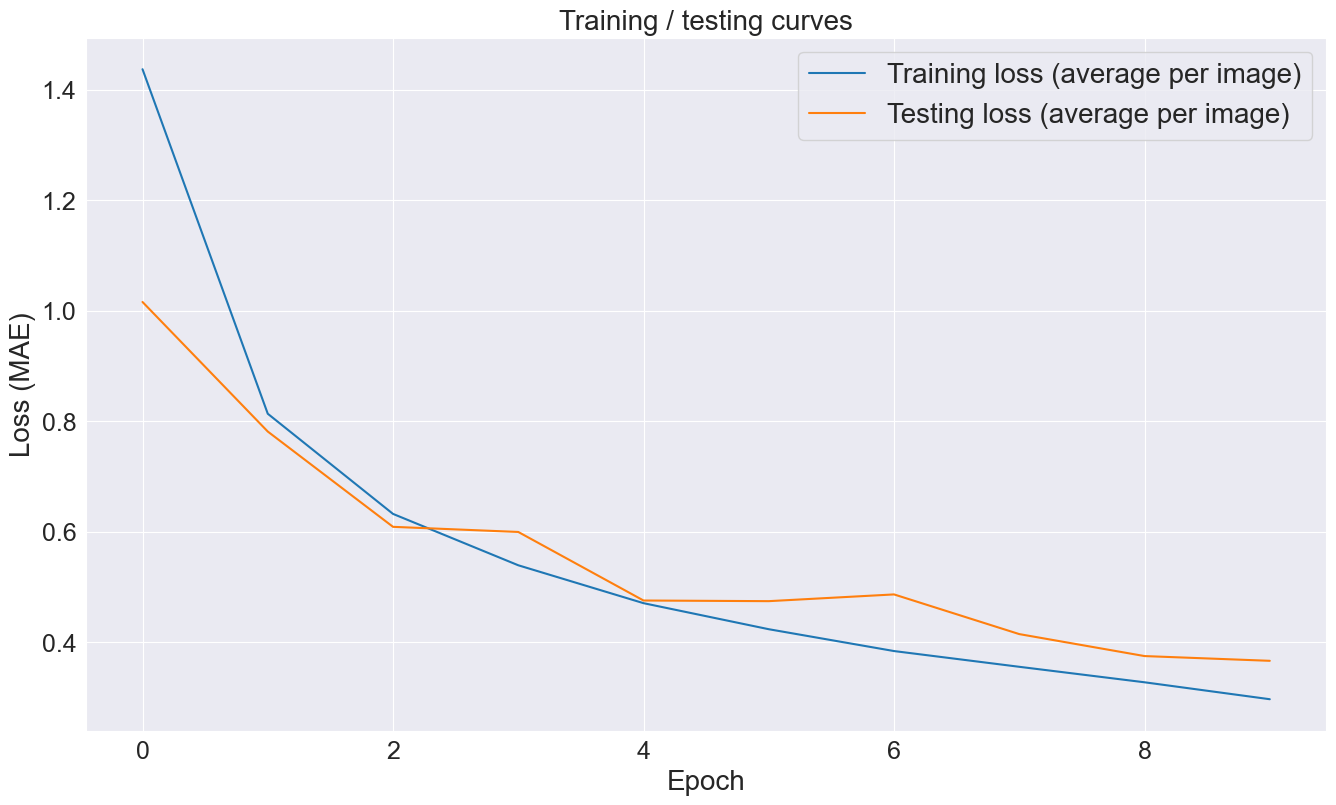

In [60]:
import numpy as np

_, ax = plt.subplots(figsize=(16, 9))
ax.plot(
    np.array(train_losses)
    / (
        4 * (len(train_loader))
    ),  # The array contains losses over the *entire* dataset at each epoch, divide by batch size x number of batches
    label="Training loss (average per image)",
)
ax.plot(
    np.array(test_losses) / (100 * len(test_loader)),
    label="Testing loss (average per image)",
)
ax.tick_params(axis="both", which="major", labelsize=18)
ax.set_xlabel("Epoch", fontsize=20)
ax.set_ylabel("Loss (MAE)", fontsize=20)
ax.set_title("Training / testing curves", fontsize=20)
_ = ax.legend(fontsize=20)
# plt.savefig('q5-training-plot.png')

Judging by the consistent decrease in both training and testing loss, no overfitting has taken place and the learning rate allowed the model to move towards the minimum without resetting its own progress with large jumps. Furthermore, the generalisation gap looks to be quite low, suggesting that overfitting is unlikely to have taken place.

## Visualise some predictions

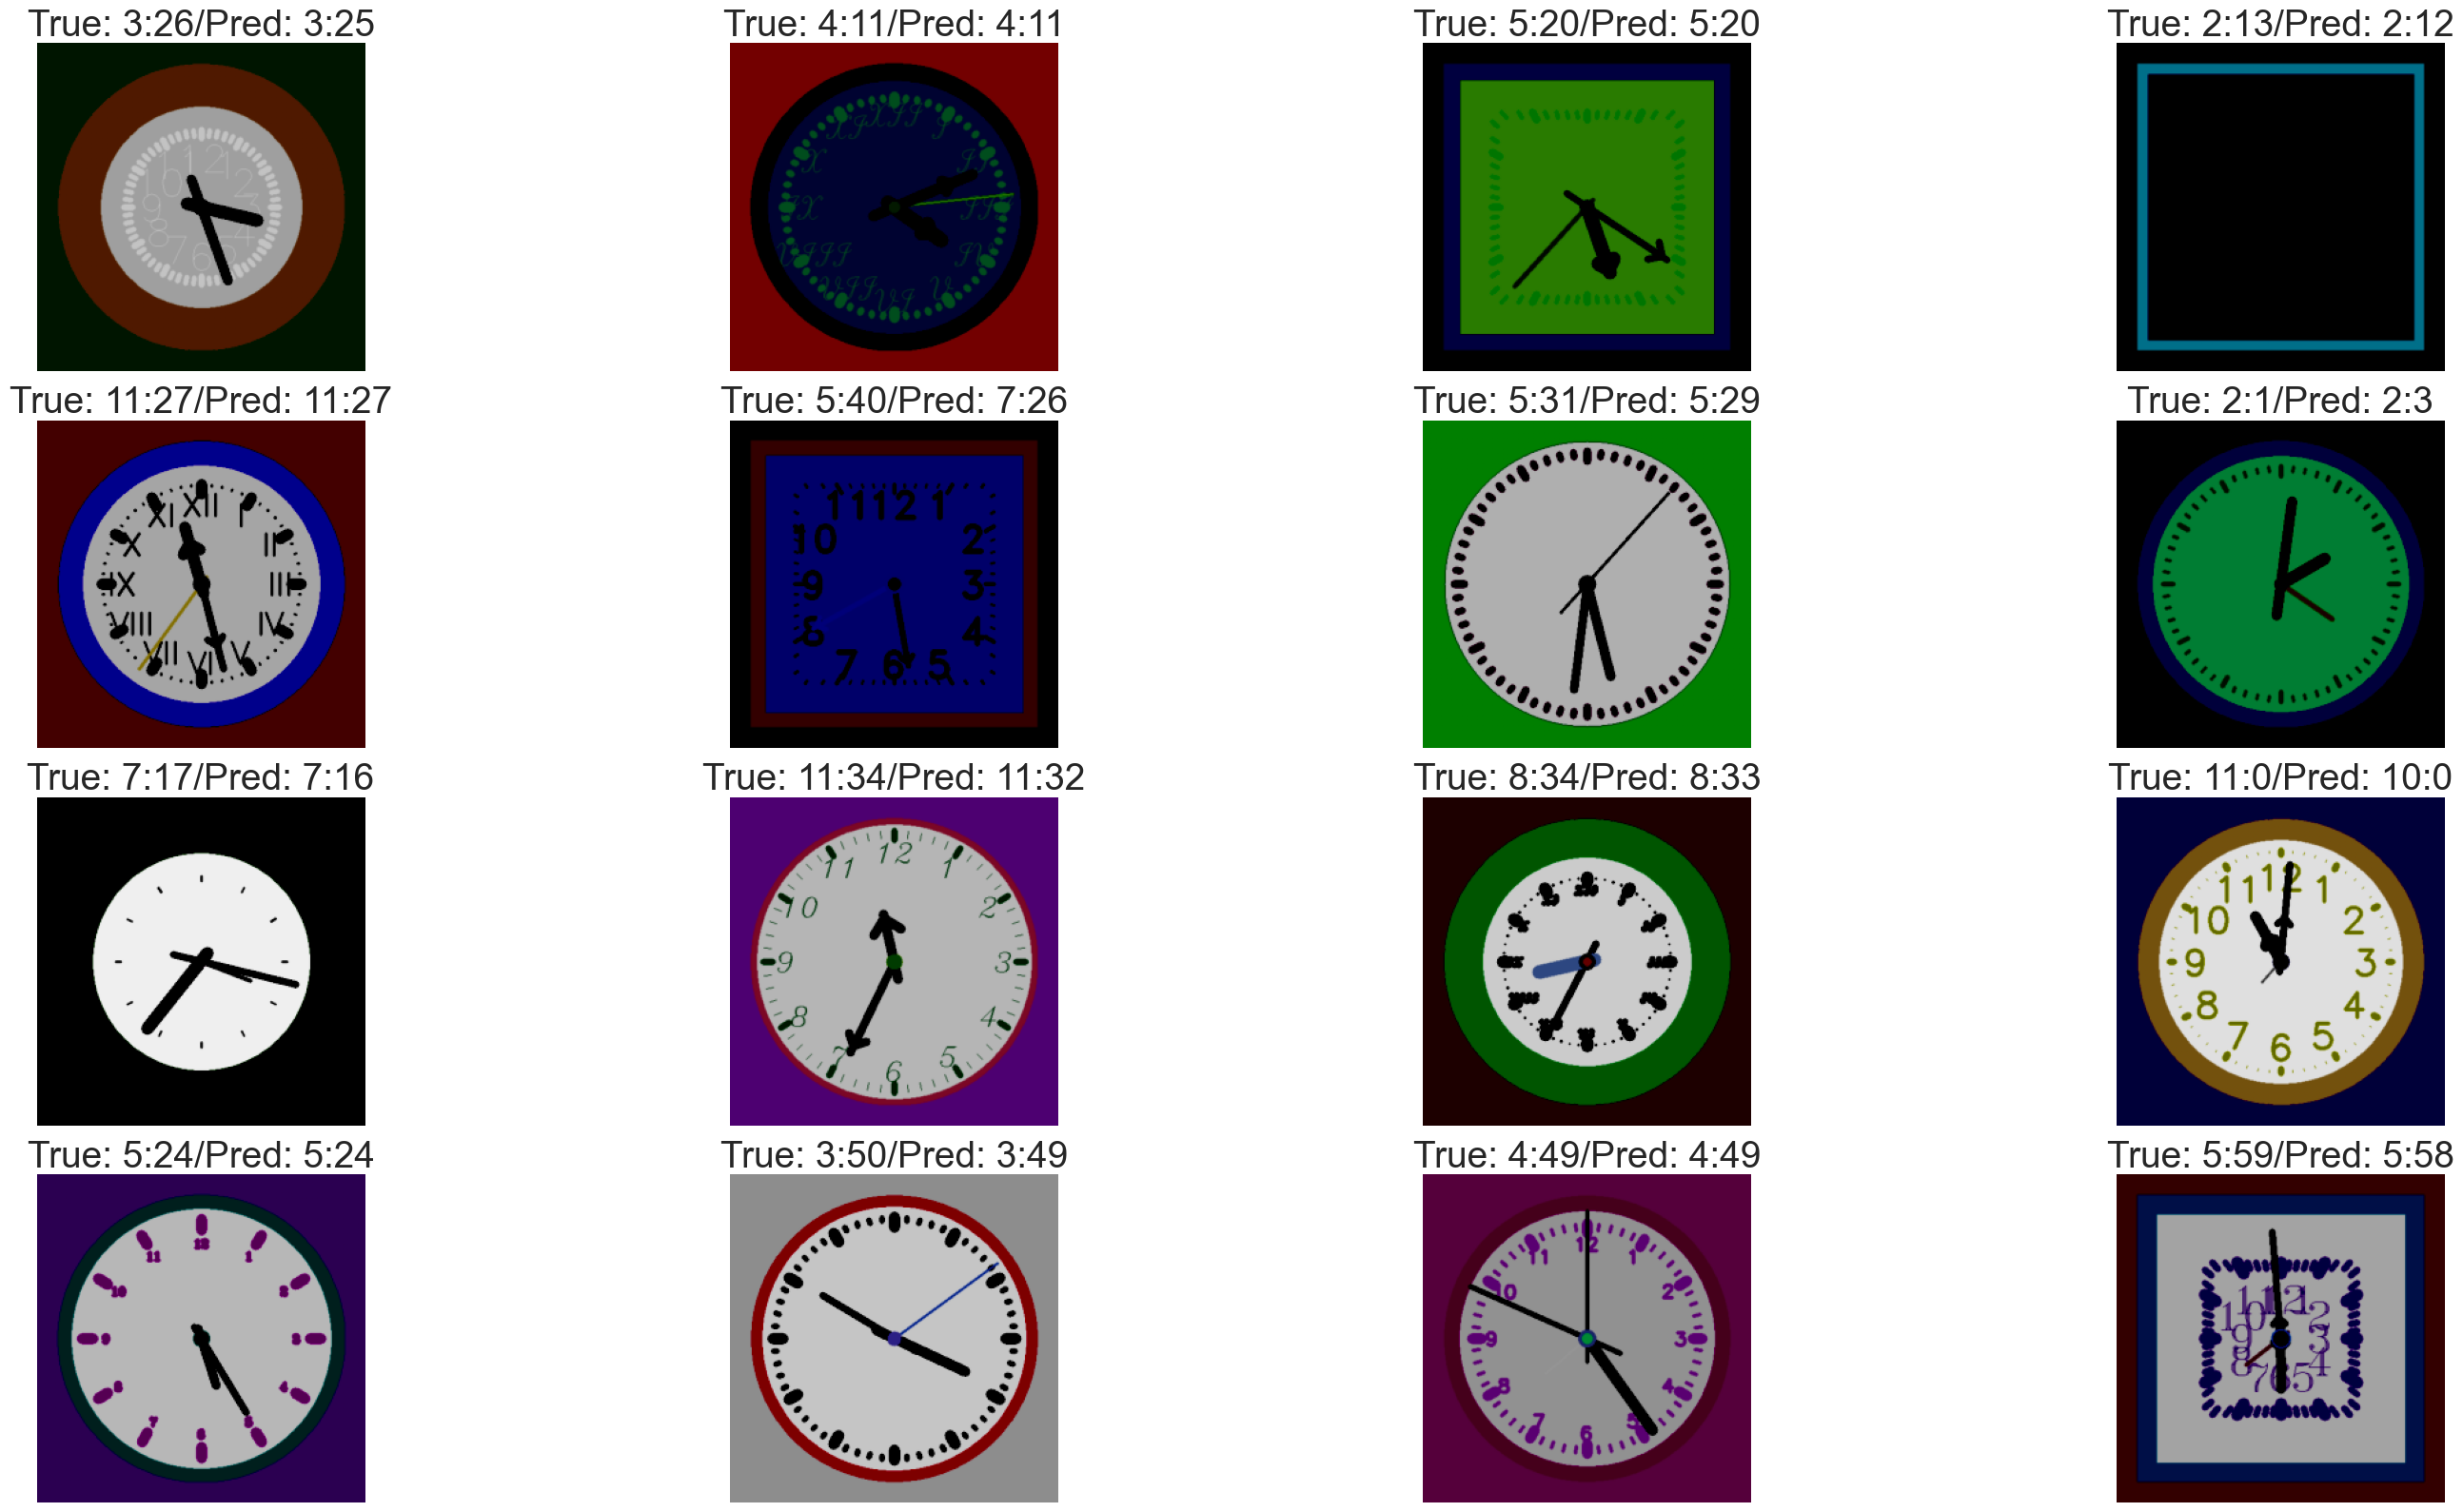

In [67]:
model.eval()
images, labels, display_labels = next(iter(test_loader))
output = model(images.to(DEVICE))

# Display first 16 images with predicted labels
figure = plt.figure(figsize=(32, 16))
for i in range(16):
    figure.add_subplot(4, 4, i + 1)
    plt.title(
        "True: {}/Pred: {}".format(
            display_labels[i],
            ":".join(
                map(lambda x: str(round(x)), sin_cos_to_clock(*output[i].tolist()))
            ),
        ),
        fontsize=28,
    )
    plt.axis("off")
    plt.imshow(images[i, :].squeeze().clamp(0, 1).permute(1, 2, 0), cmap="gray")
figure.tight_layout()
plt.show()

Overall, the model's predictions seem to be relatively accurate - the thickness of the arrows seems to have a negative effect on the result, often leading to an "off-by-one" error in the hour reading (seen in row 1, column 4). Despite that, most predictions seem to be off by a few minutes at most. Furthermore, the model seems to have learned to ignore second/alarm hands as seen on its prediction in row 3, column 3 and row 4, column 3.

## Calculate the median error on the testing set to examine the model's performance in the assessment criterion

In [34]:
def absolute_difference(msm_1, msm_2):
    """
    Calculate the absolute difference between two clock readings, in the form of minutes passed since midnight (going clockwise)
    :param msm_1: Minutes since midnight [0, 11*60 + 59)
    :param msm_2: Minutes since midnight [0, 11*60 + 59)
    :return: The absolute difference, in minutes
    """
    return min(
        int(abs(msm_1 - msm_2)),
        int(
            (12 * 60) - abs(msm_1 - msm_2)
        ),  # If difference is over 6 hours, count difference going the opposite way i.e. return the smaller difference
    )


time_1 = 5  # 00:05
time_2 = 11 * 60 + 55  # 11:55
assert (
    absolute_difference(time_1, time_2) == 10
)  # Shortest "distance" is counterclockwise

time_1 = 3 * 60 + 35  # 03:35
time_2 = 7 * 60 + 40  # 07:40
assert (
    absolute_difference(time_1, time_2) == 4 * 60 + 5
)  # Shortest "distance" is clockwise

Median absolute error over 1000 images is 1.0 minutes, mean is 14.445, min is 0, max is 299


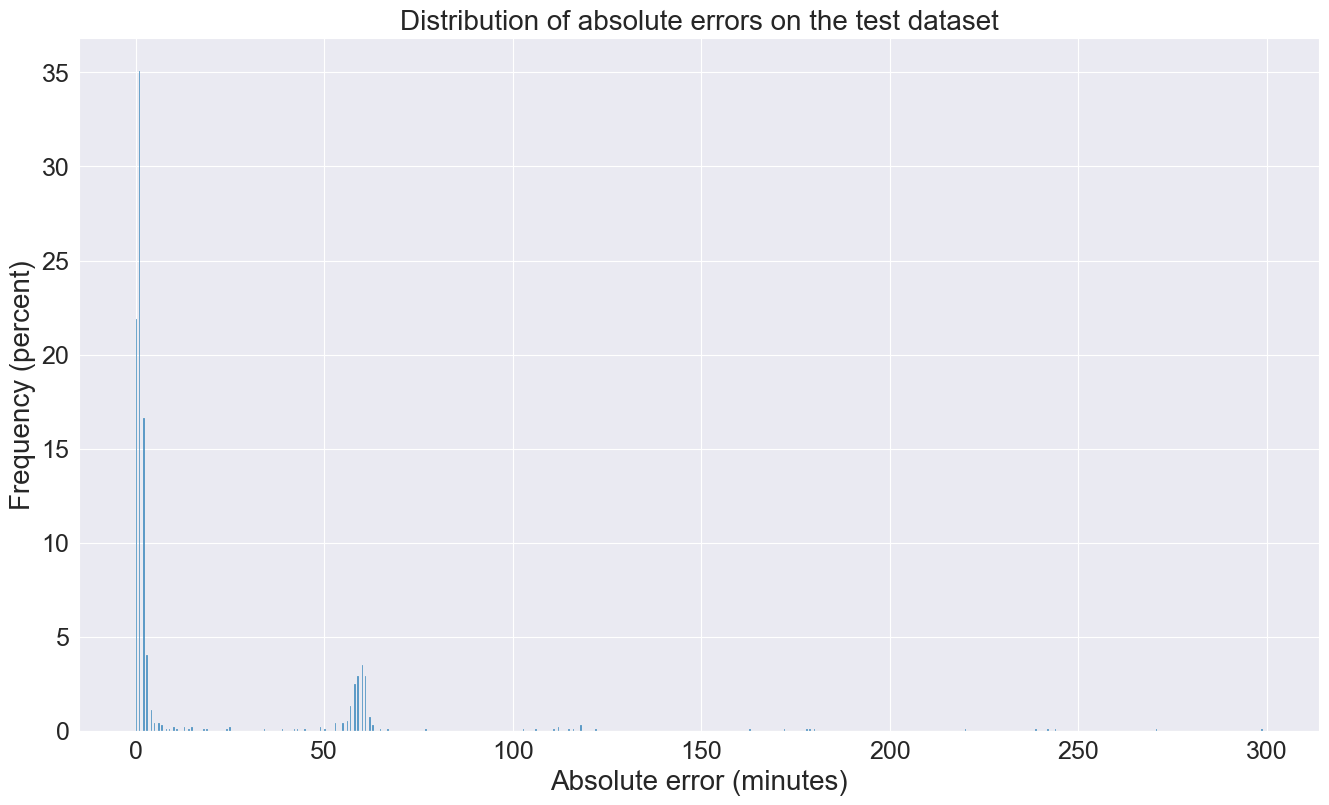

In [68]:
import numpy as np
import seaborn as sns

all_labels, all_outputs = (
    torch.tensor([], device=DEVICE),
    torch.tensor([], device=DEVICE),
)

for _, (imgs, labels, _) in enumerate(test_loader):
    all_labels = torch.cat((all_labels, labels.to(DEVICE)))
    with torch.no_grad():
        output = model(imgs.to(DEVICE))
    all_outputs = torch.cat((all_outputs, output))

_, ax = plt.subplots(figsize=(16, 9))
mins_since_midnight_true = [
    sin_cos_to_clock(*item.tolist())[0] * 60
    + int(np.round(sin_cos_to_clock(*item.tolist())[1]))
    for item in all_labels
]
mins_since_midnight_pred = [
    sin_cos_to_clock(*item.tolist())[0] * 60
    + int(np.round(sin_cos_to_clock(*item.tolist())[1]))
    for item in all_outputs
]

diffs = [
    absolute_difference(pred, true)
    for pred, true in zip(mins_since_midnight_pred, mins_since_midnight_true)
]
print(
    f"Median absolute error over {len(diffs)} images is {round(np.median(diffs), 3)} minutes, mean is {round(np.mean(diffs), 3)}, min is {round(np.min(diffs), 3)}, max is {round(np.max(diffs), 3)}"
)

sns.histplot(diffs, stat="percent", ax=ax)
ax.set_xlabel("Absolute error (minutes)", fontsize=20)
ax.set_title("Distribution of absolute errors on the test dataset", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=18)
_ = ax.set_ylabel("Frequency (percent)", fontsize=20)

Similar to what was seen on the visual output of some testing images, the spike around 60 likely corresponds to the model being mistaken by an hour for clocks where the hour hand is larger than usual.

%Latex
\pagebreak

# Question 6

No need to split training and testing data this time, train on entire dataset

Define some constants used for training.
Note the relatively small size of the latent vector - while the clock dataset is relatively varied in terms of their appearance, the look of a clock is only determined by a few variables (background colour, marking font, hour colour, etc.)
Therefore, a smaller latent representation may be beneficial for this task.

In [154]:
batch_size = 10
nz = 50  # Size of z latent vector (i.e. size of generator input)
ngf = 128  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
lr = 0.0002  # Learning rate for optimizers
beta1 = 0.5  # Beta1 hyperparameter for Adam optimizers

In [159]:
transform = v2.Compose(
    [
        v2.Resize(
            (32, 32)
        ),  # Significantly reduce the resolution - at that size, the "clock" features like hands, markings and shape are still visible but quite blurry
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        v2.RandomChannelPermutation(),  # Safe (but slightly limited) way to augment the data - we get a completely different colouring but hte same shape and hand positioning
    ]
)
dataset = ClocksDataset("train", transform)
data_loader = DataLoader(dataset, batch_size=batch_size)

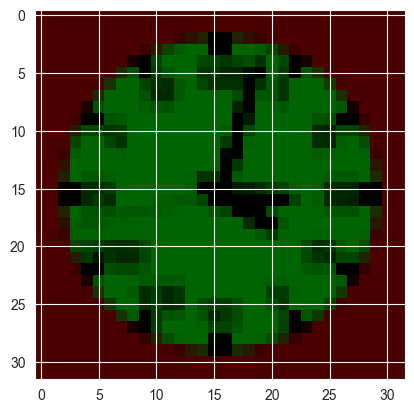

In [160]:
img, _, _ = dataset[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))

Define the generator network - aiming for a 32x32 output and mirroring the DCGAN architecture - its success on generating faces suggests this architecture can be successful at generating simpler images such as clocks.

In [162]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)


netG = Generator()
netG = netG.to(DEVICE)

Check the output of the generator has correct dimensions.

env: PYTORCH_ENABLE_MPS_FALLBACK=1
torch.Size([3, 3, 32, 32])


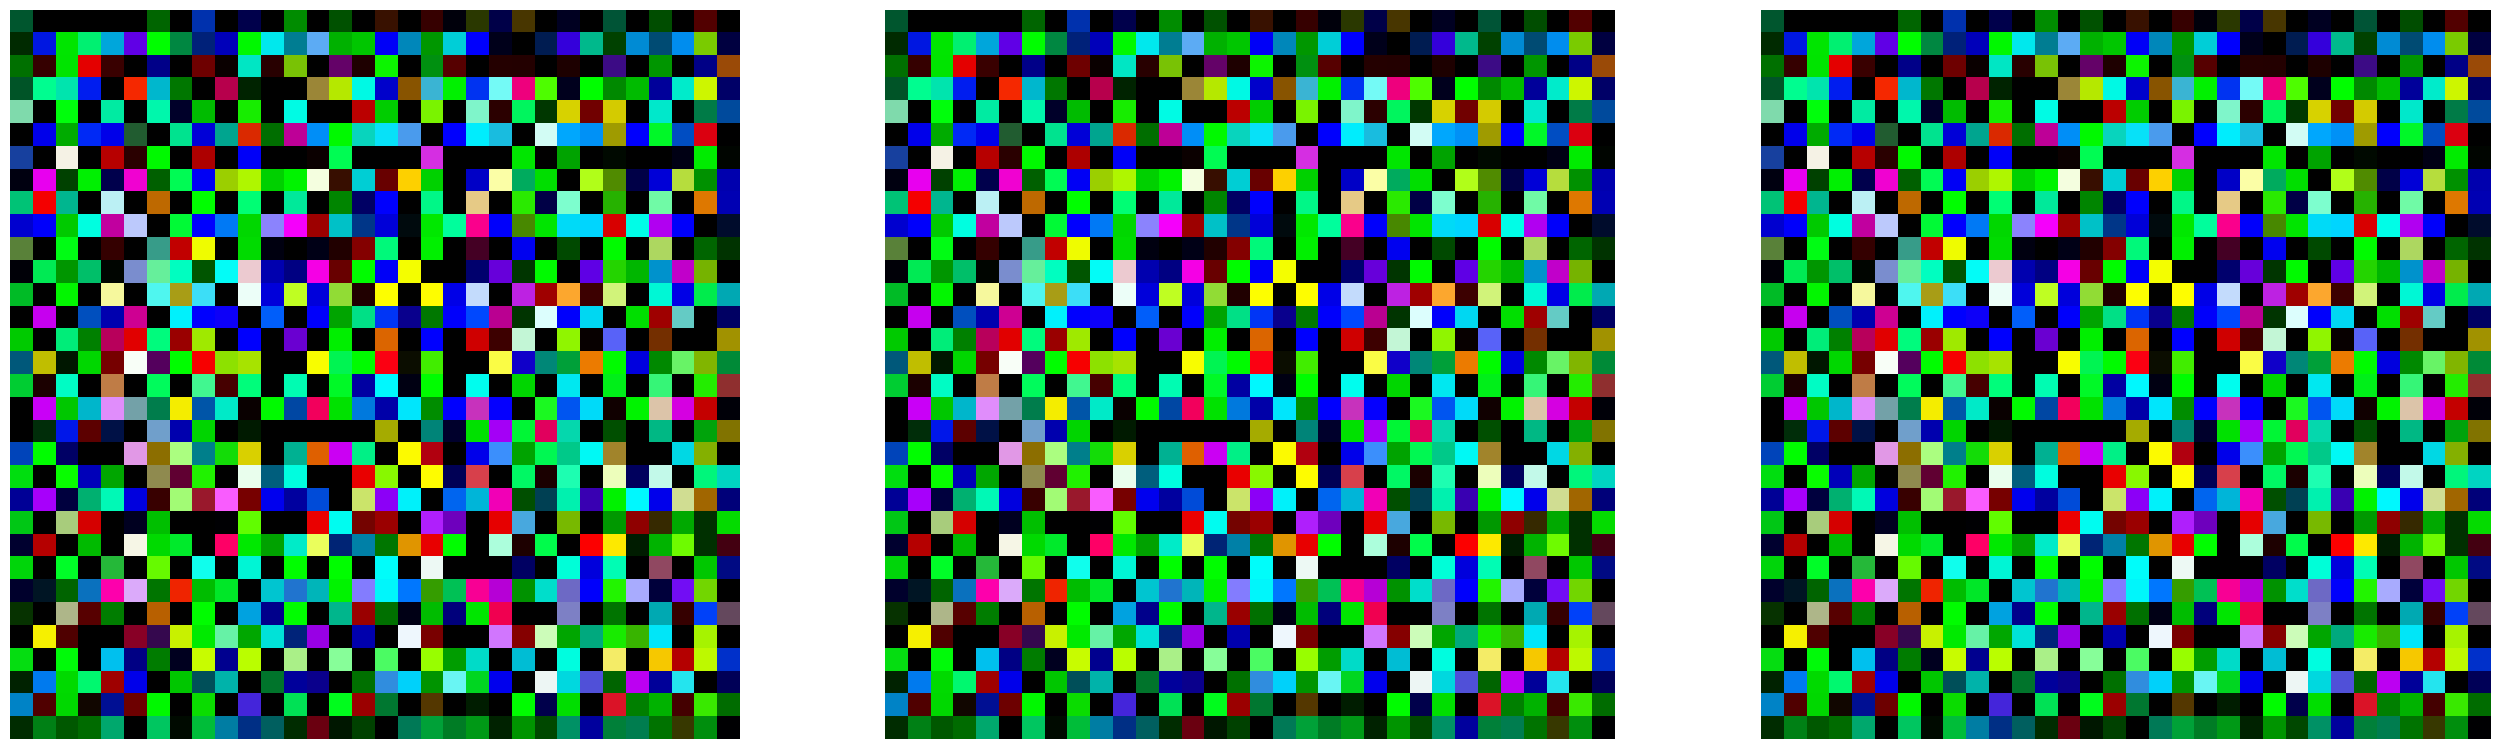

In [163]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1
random_z = torch.randn(3, nz, 1, 1, dtype=torch.float32).to(DEVICE)
random_out = netG(random_z)
print(random_out.shape)
fig, ax = plt.subplots(1, 3, figsize=(32, 32))
for idx, img in enumerate(random_out):
    ax[idx].imshow(
        img.squeeze(0).squeeze(0).permute(1, 2, 0).clamp(0, 1).cpu().detach().numpy()
    )
    ax[idx].axis("off")

Define the discriminator network - goal is to reduce a 64x64 image to a single value, representing whether it is real or fake.

In [164]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = torch.nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


netD = Discriminator()
netD = netD.to(DEVICE)

Test the output of the discriminator is of the expected shape

In [165]:
random_z = torch.randn(1, nz, 1, 1).to(DEVICE)
random_out = netG(random_z)
netD(random_out).shape

torch.Size([1, 1, 1, 1])

Define the loss function for the discriminator network - since the only task of the discriminator is labelling an image as real or fake, the binary cross entropy loss fits the task best.

In order to keep the PDF at a manageable size, per-batch statistics will not be printed.

In [193]:
criterion = nn.BCELoss()
num_epochs = 20
# Establish convention for real and fake labels during training (apply the label smoothing technique - it seems to work well for this task)
real_label = 0.9
fake_label = 0.1

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(
    netG.parameters(), lr=lr * 2, betas=(beta1, 0.999)
)  # the generator benefits from a faster learning rate, double it compared to the discriminator
# For each epoch
for epoch in range(num_epochs):
    print(f"========Epoch {epoch + 1}===========")
    # For each batch in the dataloader
    for i, (images, _, _) in enumerate(data_loader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_images = images.to(DEVICE)
        label = torch.full(
            (batch_size,), real_label, dtype=torch.float32, device=DEVICE
        )
        # Forward pass real batch through D
        output = netD(real_images).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        z = torch.randn(batch_size, nz, 1, 1, device=DEVICE)
        # Generate fake image batch with G
        fake = netG(z)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

========Epoch 1===========
========Epoch 2===========
========Epoch 3===========
========Epoch 4===========
========Epoch 5===========
========Epoch 6===========
========Epoch 7===========
========Epoch 8===========
========Epoch 9===========
========Epoch 10===========
========Epoch 11===========
========Epoch 12===========
========Epoch 13===========
========Epoch 14===========
========Epoch 15===========
========Epoch 16===========
========Epoch 17===========
========Epoch 18===========
========Epoch 19===========
========Epoch 20===========


## Generate 8 random clock images

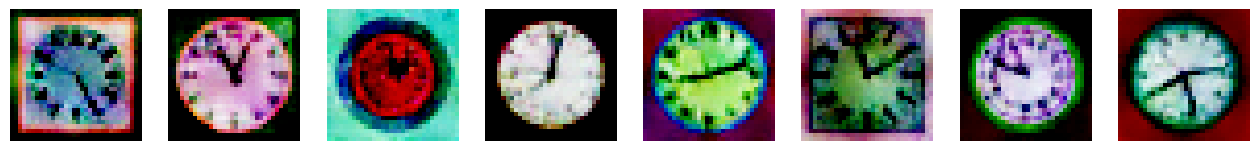

In [198]:
fig, ax = plt.subplots(1, 8, figsize=(16, 8))
for i in range(8):
    z = torch.randn(1, nz, 1, 1).to(DEVICE)
    gen = netG(z)
    ax[i].axis("off")
    ax[i].imshow(
        gen.squeeze(0).squeeze(0).permute(1, 2, 0).clamp(0, 1).cpu().detach().numpy()
    )

It is clear that the model has learned the features that make up a clock - the hands are visible on most images and some show the clock markings. The model also shows an acceptable variety of colours and shapes, with more round clocks than square ones.

## Linear interpolation demo

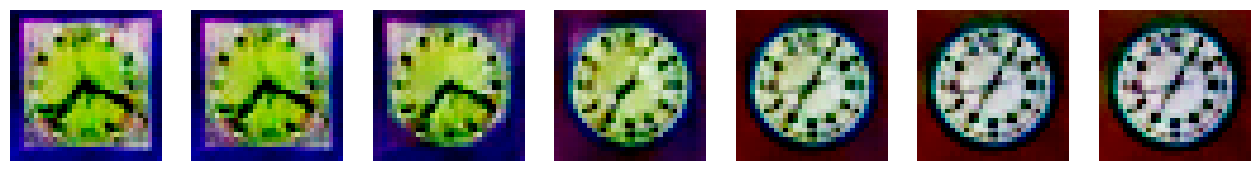

In [213]:
import numpy as np

fig, ax = plt.subplots(1, 7, figsize=(16, 8))
z1, z2 = torch.randn(1, nz, 1, 1).to(DEVICE), torch.randn(1, nz, 1, 1).to(DEVICE)
intermediates = [z1]
for i in np.arange(1, 10, 2):  # Only 5 images are needed, move in steps of 2
    intermediates.append((z1 * (1 - (i / 10))) + (z2 * (i / 10)))
intermediates.append(z2)

for idx, img in enumerate(intermediates):
    ax[idx].imshow(
        netG(img)
        .squeeze(0)
        .squeeze(0)
        .permute(1, 2, 0)
        .clamp(0, 1)
        .cpu()
        .detach()
        .numpy(),
    )
    ax[idx].axis("off")